In [62]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.stats import kurtosis, skew
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

In [63]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [65]:
# Test Data
test_directory = input_directory+'/testX'
test_routes = sorted(glob(os.path.join(test_directory, "*.jpg")))
print(len(test_routes))

2121


In [66]:
#Training set organization
train_bcc= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [67]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [68]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

2713
2713
2632
498
678
94


In [69]:
#Training set DataFrame construction
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [70]:
#Validation set DataFrame construction
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [71]:
#Test set DataFrame construction
tags_test = []
for i in range(len(test_routes)):
  tags_test.append(test_routes[i][-12:])

In [72]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [73]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [74]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [75]:
test_set = pd.DataFrame.from_dict({'Image Tag':tags_test, 'Image Route': test_routes})

In [76]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [77]:
test_data = test_set['Image Route'].to_numpy()

In [78]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [79]:
def color_histogram_features(imr):
  color_histogram=[]
  for i in imr:
    image_read= cv2.imread(i)
    # bgr= cv2.split(image_read)
    image_hsv = cv2.cvtColor(image_read, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(image_hsv)
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    ch = clahe.apply(h)
    cs = clahe.apply(s)
    cv = clahe.apply(v)
    clahe_img = [ch,cs,cv]
    histSize=64
    histRange=(0,256)
    accumulate= False 
    h_hist = cv2.calcHist(clahe_img, [0], None, [histSize], histRange)
    s_hist = cv2.calcHist(clahe_img, [1], None, [histSize], histRange)
    v_hist = cv2.calcHist(clahe_img, [2], None, [histSize], histRange)
    hsv_hist= np.concatenate((h_hist,s_hist,v_hist),axis=None).T
    color_histogram.append(hsv_hist)
  
  features_color_histogram= pd.DataFrame(color_histogram)
  
  return features_color_histogram

In [61]:
# X_train_features = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/hsv_Train_HistogramColorFeatures291022.csv')
# X_test_features = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/hsv_Test_HistogramColorFeatures291022.csv')

In [20]:
test_features = color_histogram_features(test_data)

In [80]:
X_train_features= color_histogram_features(X_train)
X_test_features= color_histogram_features(X_test)
# scaler= StandardScaler().fit(X_train_features)
# X_train_scaled= scaler.transform(X_train_features)
# X_test_scaled= scaler.transform(X_test_features)

In [81]:
X_train = X_train_features
X_test = X_test_features
X_train_old_columns= X_train.columns
X_train.columns=[y for y in range(len(X_train.columns))]
X_test_old_columns= X_test.columns
X_test.columns=[y for y in range(len(X_test.columns))]
scaler= StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [82]:
test_scaled = scaler.transform(test_features)

In [123]:
# X_train_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/hsv_Train_HistogramColorFeatures291022.csv',index=False)
# X_test_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblem_Data/hsv_Test_HistogramColorFeatures291022.csv',index=False)

First model: SVM

In [84]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [85]:
# pickle.dump(model1, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/ColorHistSVM_model.sav', 'wb'))

In [86]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       678
           1       0.74      0.70      0.72       498
           2       0.25      0.56      0.35        94

    accuracy                           0.73      1270
   macro avg       0.63      0.68      0.63      1270
weighted avg       0.79      0.73      0.75      1270

0.679520189589085
Kappa Score :
0.545651197231143


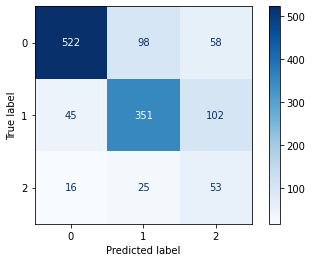

In [87]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [88]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [89]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72       678
           1       0.67      0.59      0.63       498
           2       0.15      0.44      0.22        94

    accuracy                           0.62      1270
   macro avg       0.54      0.56      0.52      1270
weighted avg       0.70      0.62      0.65      1270

0.5619412313157733
Kappa Score :
0.37467460397538077


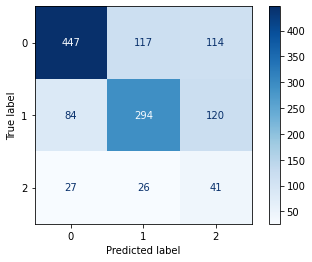

In [90]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [91]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [92]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       678
           1       0.77      0.72      0.75       498
           2       0.28      0.53      0.37        94

    accuracy                           0.75      1270
   macro avg       0.64      0.69      0.65      1270
weighted avg       0.79      0.75      0.77      1270

0.6857221139626604
Kappa Score :
0.572832977822057


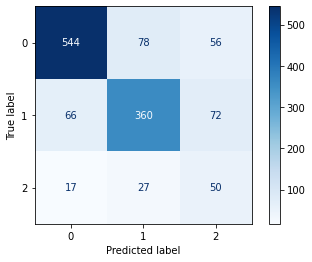

In [93]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [94]:
# pickle.dump(model3, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/ColorHistGBoost_model.sav', 'wb'))

Fourth Model: Random Forest Classifier

In [95]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [96]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       678
           1       0.80      0.83      0.81       498
           2       0.45      0.59      0.51        94

    accuracy                           0.82      1270
   macro avg       0.72      0.75      0.73      1270
weighted avg       0.83      0.82      0.82      1270

0.7518467770536108
Kappa Score :
0.6796053522517289


In [97]:
# pickle.dump(model4, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/ColorHistRF_model.sav', 'wb'))

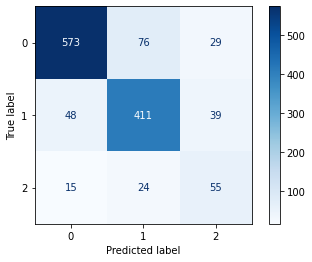

In [98]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [99]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [100]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       678
           1       0.70      0.58      0.63       498
           2       0.18      0.43      0.25        94

    accuracy                           0.66      1270
   macro avg       0.56      0.59      0.56      1270
weighted avg       0.72      0.66      0.69      1270

0.5879884314764865
Kappa Score :
0.4347212435319576


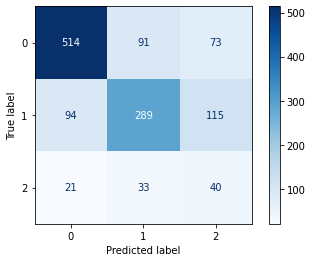

In [101]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [102]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [103]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74       678
           1       0.66      0.61      0.64       498
           2       0.20      0.49      0.28        94

    accuracy                           0.64      1270
   macro avg       0.55      0.59      0.55      1270
weighted avg       0.70      0.64      0.66      1270

0.5942314415510533
Kappa Score :
0.40115602403671546


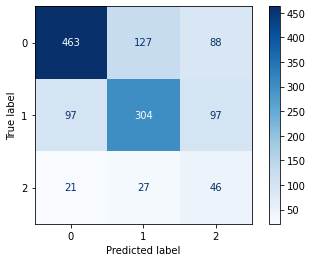

In [104]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [105]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [106]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       678
           1       0.77      0.73      0.75       498
           2       0.25      0.50      0.34        94

    accuracy                           0.74      1270
   macro avg       0.63      0.67      0.64      1270
weighted avg       0.78      0.74      0.76      1270

0.6705642629515111
Kappa Score :
0.5566862002580972


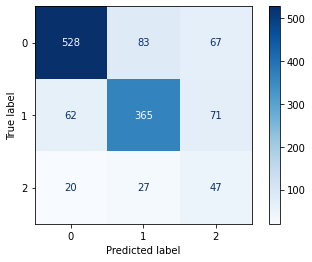

In [107]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [108]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)

In [109]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.84      0.44      0.58       678
           1       0.50      0.90      0.64       498
           2       0.19      0.03      0.05        94

    accuracy                           0.59      1270
   macro avg       0.51      0.46      0.42      1270
weighted avg       0.66      0.59      0.56      1270

0.45719147222165507
Kappa Score :
0.2835533553355335


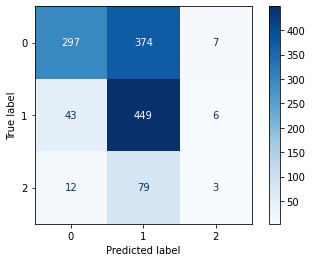

In [110]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [111]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [112]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       678
           1       0.74      0.68      0.71       498
           2       0.27      0.55      0.36        94

    accuracy                           0.73      1270
   macro avg       0.62      0.67      0.63      1270
weighted avg       0.77      0.73      0.74      1270

0.674197070715549
Kappa Score :
0.5375881764415344


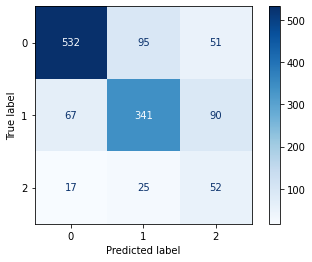

In [113]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [114]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [115]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       678
           1       0.80      0.80      0.80       498
           2       0.40      0.59      0.48        94

    accuracy                           0.80      1270
   macro avg       0.70      0.74      0.71      1270
weighted avg       0.82      0.80      0.81      1270

0.7400177500310664
Kappa Score :
0.6551626763286283


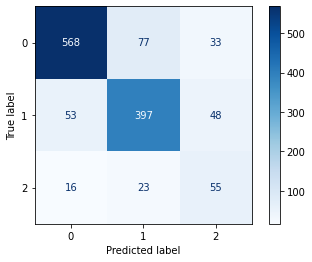

In [116]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [117]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [118]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [119]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       678
           1       0.82      0.84      0.83       498
           2       0.51      0.56      0.54        94

    accuracy                           0.84      1270
   macro avg       0.74      0.76      0.75      1270
weighted avg       0.84      0.84      0.84      1270

0.7584672462523162
Kappa Score :
0.7079090997549692


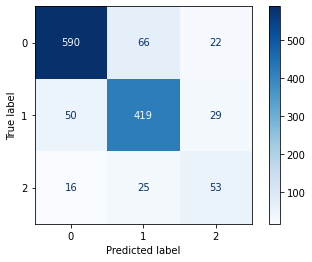

In [120]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [122]:
pickle.dump(model11, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/Best_Model.sav', 'wb'))

**Best Model**

In [124]:
best_model = pickle.load(open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/Best_Model.sav', 'rb'))

In [125]:
y_pred_best = best_model.predict(X_test_scaled)

In [126]:
print(classification_report(y_test,y_pred_best))
print(balanced_accuracy_score(y_test,y_pred_best))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred_best))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       678
           1       0.82      0.84      0.83       498
           2       0.51      0.56      0.54        94

    accuracy                           0.84      1270
   macro avg       0.74      0.76      0.75      1270
weighted avg       0.84      0.84      0.84      1270

0.7584672462523162
Kappa Score :
0.7079090997549692


**Predictons**

In [127]:
fin_pred= best_model.predict(test_scaled)

In [128]:
predictions={'Image Tag':np.array(tags_test), 'Predicted label':fin_pred}

In [129]:
final_predictions= pd.DataFrame.from_dict(predictions)

In [130]:
count_zero = np.count_nonzero(final_predictions == 0)
print(count_zero)
count_one = np.count_nonzero(final_predictions == 1)
print(count_one)
count_two = np.count_nonzero(final_predictions == 2)
print(count_two)

1087
874
160


In [131]:
print(final_predictions)

         Image Tag  Predicted label
0     xxx00001.jpg                2
1     xxx00002.jpg                1
2     xxx00003.jpg                1
3     xxx00004.jpg                0
4     xxx00005.jpg                0
...            ...              ...
2116  xxx02117.jpg                0
2117  xxx02118.jpg                1
2118  xxx02119.jpg                2
2119  xxx02120.jpg                1
2120  xxx02121.jpg                1

[2121 rows x 2 columns]


In [132]:
final_predictions.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Final Predictions/ThreeClass/Predictions_ThreeClass.csv',index=False)

In [133]:
final_predictions.to_excel('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Final Predictions/ThreeClass/Predictions_ThreeClass.xlsx', index=False)

In [134]:
print(final_predictions)

         Image Tag  Predicted label
0     xxx00001.jpg                2
1     xxx00002.jpg                1
2     xxx00003.jpg                1
3     xxx00004.jpg                0
4     xxx00005.jpg                0
...            ...              ...
2116  xxx02117.jpg                0
2117  xxx02118.jpg                1
2118  xxx02119.jpg                2
2119  xxx02120.jpg                1
2120  xxx02121.jpg                1

[2121 rows x 2 columns]
